In [1]:
# Playing about with the RHESSI flare list
# 
# The full list is here:
# https://hesperia.gsfc.nasa.gov/hessidata/dbase/hessi_flare_list.txt
# Containing 121,206 (previous 121,180 was old txt not updated, though ssw was)
# 
# What is loaded in here is produced in ssw/idl, make_rfl_forpy.pro in which
# put the full RHESSI flare list into format for python and
# use selection of flag info and highlight if also in the list from 
# Loumou, Hannah & Hudson 2018 (LHH) https://doi.org/10.1051/0004-6361/201731050
# (i.e. solar position, good RAS and gives pre-flare background subtracted 
# GOES 1-8 >=1e-8, total 75,307 events.) 
# 
# 10-Nov-2020 - Started, based on rhsi_fl.ipynb
# 19-Nov-2020 - Updated to show duplicate events (3 of them)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from astropy import time
import astropy.units as u

import warnings
warnings.simplefilter('ignore')

In [3]:
fl=io.readsav('rfl_py_full.dat')
# Have produced 3 versions
# rfl_py_full.dat which contains most info (ids, times, positions, flags, goes, lhh pos)
# rfl_py_mid.dat which contains some infor (ids, times, flags, goes)
# rfl_py_simp.dat which contains minimal info (ids, times, flags)

In [4]:
print(fl.keys())

dict_keys(['id_num', 'x', 'y', 'lat', 'lng', 'ptim', 'stim', 'etim', 'enghi', 'a0only', 'sflag1', 'saa', 'ecl', 'dgp', 'lhh', 'bsges', 'xlhh', 'ylhh', 'latlhh', 'lnglhh'])


In [5]:
# How many flares in total?
print('Num events: ',len(fl['id_num']))

Num events:  121206


In [6]:
# How many unique flares?
unq, unq_idx, unq_cnt = np.unique(fl['id_num'], return_inverse=True, return_counts=True)
print('Num unique events: ', len(unq))

cnt_mask = unq_cnt > 1
dup_ids = unq[cnt_mask]
print('Repeated IDs: ', dup_ids)

Num unique events:  121203
Repeated IDs:  [ 3042103 13111351 13111352]


In [7]:
#  So how many of these flares were during the shutter out times?
#  Should be mostly microflares
a0id=np.where(fl['a0only'] == 1)
# print(a0id[0].shape)
print('A0 events: ',len(a0id[0]))

# How many A0 only and detectable in 12-25 keV or higher?\
a0id12=np.where((fl['a0only'] == 1) & (fl['enghi'] >= 12))
# print(a0id12[0].shape)
print('A0 events & >12 keV: ',len(a0id12[0]))

A0 events:  111642
A0 events & >12 keV:  17254


In [8]:
#  So how many of the "good" flares were during the shutter out times?
#  By "good" here using the solar flag (sflag1) and no SAA, Eclipse or data gap
#  before/during/after flare
a0idgd=np.where((fl['a0only'] == 1) & (fl['sflag1'] == 1) & \
             (fl['dgp'] == 0) & (fl['saa'] == 0) & (fl['ecl'] == 0))

print('Good + A0 events: ',len(a0idgd[0]))

Good + A0 events:  94818


In [9]:
#  So how many of the "good" flares were shutter out and in LHH list?
a0idlhh=np.where((fl['a0only'] == 1) & (fl['lhh'] == 1))
a0idgdlhh=np.where((fl['a0only'] == 1) & (fl['sflag1'] == 1) & (fl['lhh'] == 1) & \
             (fl['dgp'] == 0) & (fl['saa'] == 0) & (fl['ecl'] == 0))

print('A0 + LHH events: ',len(a0idlhh[0]))
print('Good + A0 + LHH events: ',len(a0idgdlhh[0]))

A0 + LHH events:  69072
Good + A0 + LHH events:  61545


In [10]:
# What about just number of A, B, C, M, X flares?
# Using the pre-flare background subtracted GOES 1-8 fluxes
# Only the LHH events have these
acls=np.where((fl['bsges'] >= 1e-8) & (fl['bsges'] < 1e-7))
bcls=np.where((fl['bsges'] >= 1e-7) & (fl['bsges'] < 1e-6))
ccls=np.where((fl['bsges'] >= 1e-6) & (fl['bsges'] < 1e-5))
mcls=np.where((fl['bsges'] >= 1e-5) & (fl['bsges'] < 1e-4))
xcls=np.where((fl['bsges'] >= 1e-4) )
print('A Flares: ',len(acls[0]))
print('B Flares: ',len(bcls[0]))
print('C Flares: ',len(ccls[0]))
print('M Flares: ',len(mcls[0]))
print('X Flares: ',len(xcls[0]))

A Flares:  47432
B Flares:  22694
C Flares:  4599
M Flares:  528
X Flares:  53


In [11]:
# Check that none of the flares overlap in time
stim=[time.Time(tt.decode('utf-8'),format='isot') for tt in fl['stim']]
etim=[time.Time(tt.decode('utf-8'),format='isot') for tt in fl['etim']]


In [12]:
tdiff_start=np.zeros(len(stim)-1)
for i in range(len(stim)-1):
    tdiff_start[i]=(stim[i+1]-etim[i]).value*24.*60.*60.
    

In [13]:
# All the differences in time between one flare ending and another starting 
# shoul be at min 0 (immediately following), or bigger
print(tdiff_start.min(),tdiff_start.max())


0.0 5720612.0


In [14]:
ptims_dcyr=[]
# Get rid of the b in the time string and convert to astropy time, then decimal year
for tt in fl['ptim']:
    time_temp=time.Time(tt.decode('utf-8'),format='isot')
    ptims_dcyr.append(time_temp.decimalyear)

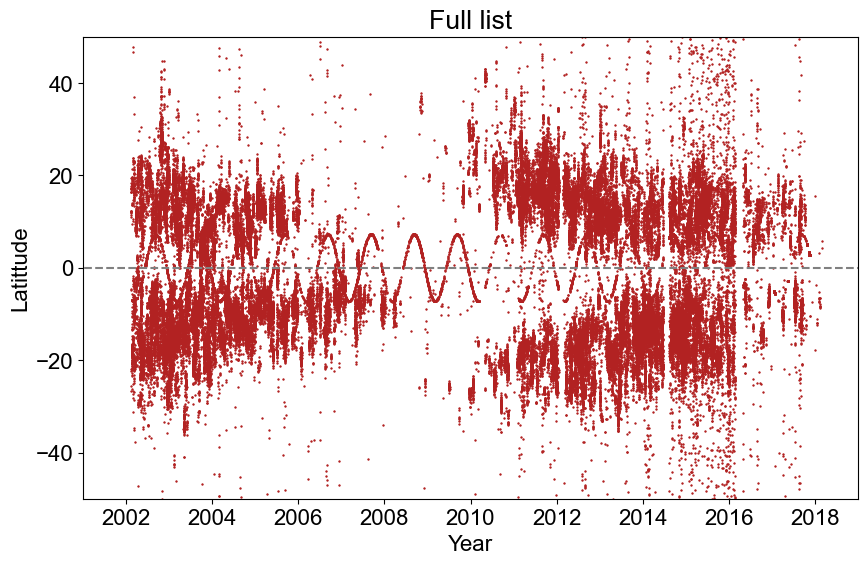

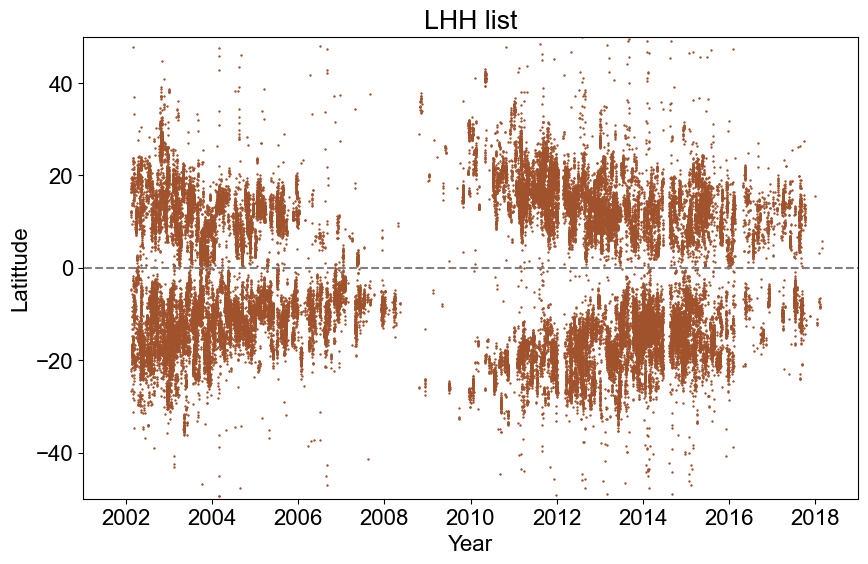

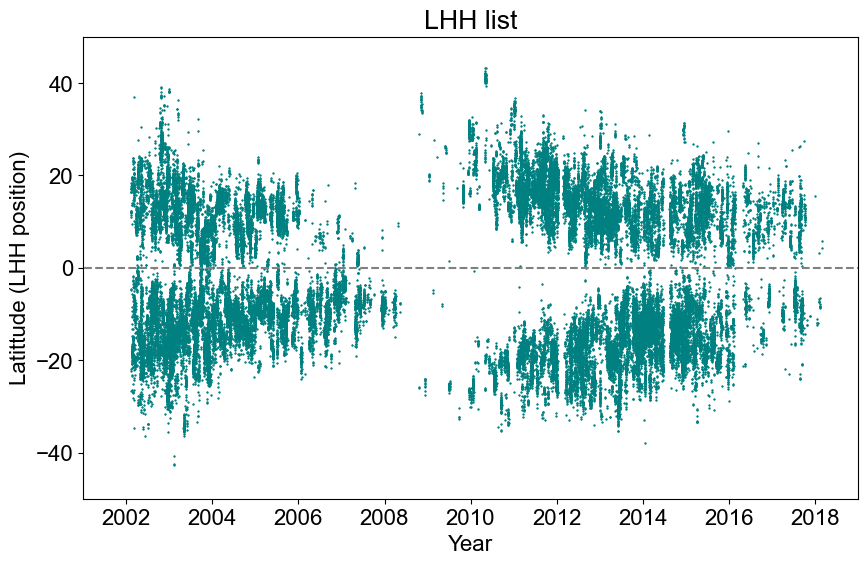

In [15]:
#  Quick Butterfly Diagram
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig = plt.figure(figsize=(10, 6))
plt.plot(ptims_dcyr,fl['lat'],marker='+',\
         markersize=1,linestyle='None',color='firebrick')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude')
plt.title('Full list')
fig.show()

idlhh=np.where((fl['lhh'] == 1))

fig = plt.figure(figsize=(10, 6))
plt.plot(np.array(ptims_dcyr)[idlhh],fl['lat'][idlhh],marker='+',\
         markersize=1,linestyle='None',color='sienna')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude')
plt.title('LHH list')
fig.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(np.array(ptims_dcyr)[idlhh],fl['latlhh'][idlhh],marker='+',\
         markersize=1,linestyle='None',color='teal')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude (LHH position)')
plt.title('LHH list')
fig.show()



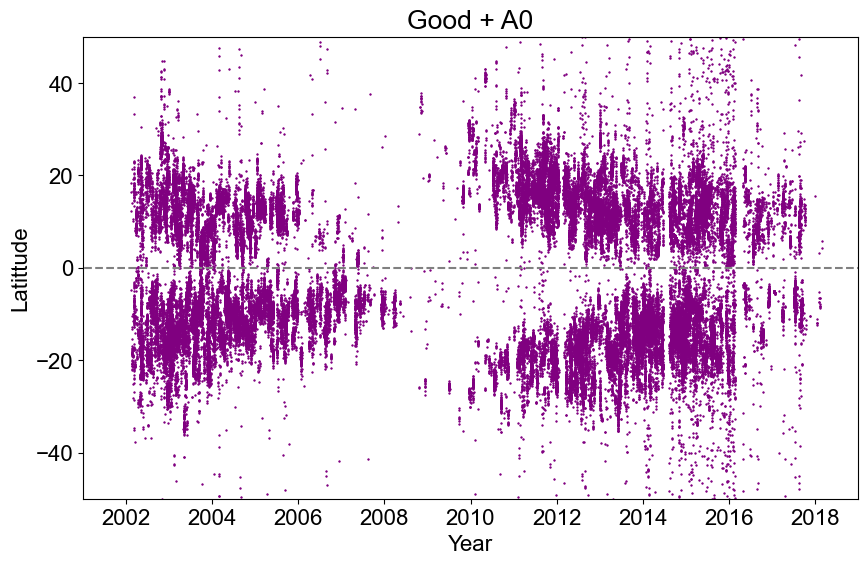

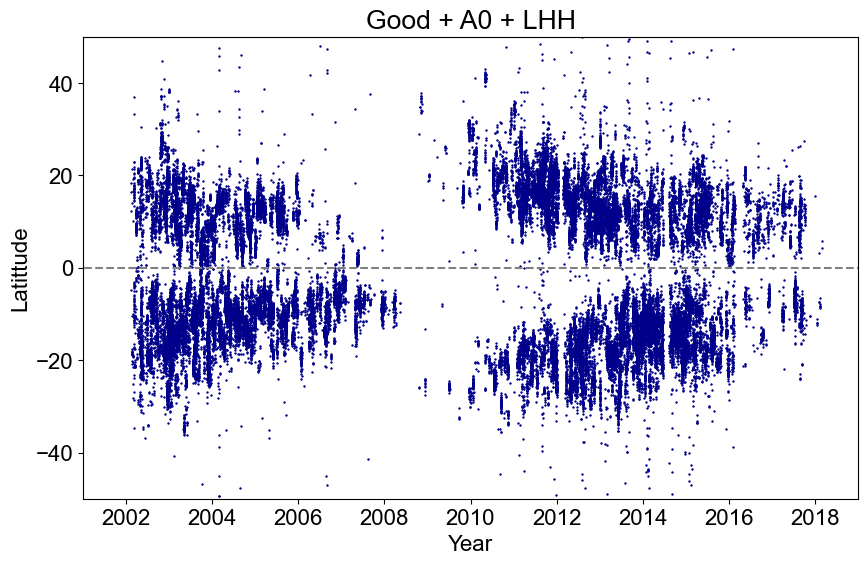

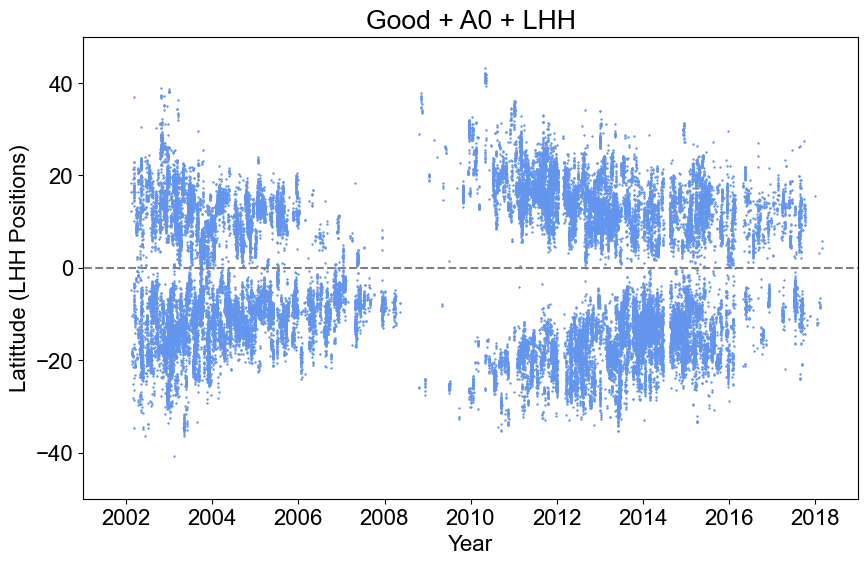

In [16]:
#  Quick Butterfly Diagram for Shutter out events
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig = plt.figure(figsize=(10, 6))
plt.plot(np.array(ptims_dcyr)[a0idgd],fl['lat'][a0idgd],\
         marker='+',markersize=1,linestyle='None',color='purple')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude')
plt.title('Good + A0')
fig.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(np.array(ptims_dcyr)[a0idgdlhh],fl['lat'][a0idgdlhh],\
         marker='+',markersize=1,linestyle='None',color='darkblue')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude')
plt.title('Good + A0 + LHH')
fig.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(np.array(ptims_dcyr)[a0idgdlhh],fl['latlhh'][a0idgdlhh],\
         marker='+',markersize=1,linestyle='None',color='cornflowerblue')
plt.plot([2000,2021],[0,0],'--',color='grey')
plt.ylim([-50,50])
plt.xlim([2001,2019])
plt.xlabel('Year')
plt.ylabel('Latittude (LHH Positions)')
plt.title('Good + A0 + LHH')
fig.show()

